# **Delivery Dron Analysis**

# **Описание проекта**
Необходимо проанализировать данные о продажах дронов доставщиков иностранной интернет компаней “Delivery Dron”, работающей в четырех регионах c мая 2019 года.
# **Задачи**

*   сделать отчет о вложенных средствах
*   построить планы на следующий год
*   **выяснить  в какой регион и какой рекламный канал инвестировать больше денег на привлечение клиентов в 2020 году**





# **Описание данных**
Файл ecom_yl.csv содержит данные о визитах и покупках пользователей сайта интернет магазина “Delivery Dron”. Каждая строка представляет визит пользователя. Данные отсортированы по Session Date.

Столбцы набора данных:

    0: User Id - id пользователя    
    1: Region - регион визита    
    2: Device - устройство, с которого производится вход на сайт    
    3: Channel - рекламный канал перехода на сайт   
    4: Session Start - время начала пользовательской сессии (входа на сайт)
    5: Session End - время окончания пользовательской сессии (уход с сайта)
    6: SessionDurationSec - длительность сессии в секундах  
    7: Session Date - дата визита  
    8: Month - месяц визита   
    9: Day - день дня недели визита  
    10: Hour of day - час (от 0 до 24) визита    
    11: Order Dt - дата покупки   
    12: Revenue - сумма покупки    
    13: Payment Type - тип оплаты
    14: Promo code - использование промокода на скидку 10% (есть-1, нет-0).


## **План:**


*    Шаг 0: Подготовка
*    Шаг 1: Исследовательский анализ данных и предобработка
*    Шаг 2: Аналитический и графический анализ данных
*    Шаг 3: Проведение расчетов
*    Шаг 4: Проверка гипотез
*    Шаг 5: Регрессионное моделирование
*    Шаг 6: Дашборд
*    Шаг 7: Выводы








# **Шаг 0: Подготовка**

## 0.1: Импорт библиотек

In [749]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
import warnings
import scipy.stats as st

## 0.2: Константы и настройки

In [750]:
warnings.filterwarnings('ignore')
TEST_SIZE = 0.15
RANDOM_STATE = 42
PALETTE = "pastel"
COLORS = ['#D0BBFE', '#FE9F9B', '#FFB482', '#A2C9F4', '#8EE5A1']

## 0.3: Загрузка данных

In [751]:
df = pd.read_csv("data.csv", sep=",")
df.head()

,User Id,Region,Device,Channel,Session Start,Session End,SessionDurationSec,Session Date,Month,Day,Hour of day,Order Dt,Revenue,Payment Type,Promo code
0,529697267522,United States,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Mobile payments,0.0
1,601292388085,United States,PC,organic,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaN,NaN,NaN,NaN
2,852898876338,United States,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaN,NaN,NaN,NaN
3,998513020664,United States,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaN,NaN,NaN,NaN
4,240702200943,United States,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaN,NaN,NaN,NaN


## 0.4: Пользовательские функции

In [752]:
def check_normality(data: pd.Series, alpha=0.05):
    """
    Проверяет нормальность выборки
    
    :param data:  выборка
    :param alpha:  уровень значимости
    :return: True, если выборка нормальна, False в противном случае
    """
    _, p = st.shapiro(data)
    return p > alpha


def quantitative_analysis(data: pd.DataFrame, factor: str):
    """
    Функция для анализа категориальных признаков и нахождения супервыбросов. Строит boxplot и hist.

    :param data: dataframe
    :param factor: название фактора
    :return: выводит два графика
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    fig.tight_layout()

    sns.histplot(data[factor], kde=True, bins=24, ax=ax1, palette=PALETTE)
    sns.boxplot(x=data[factor], ax=ax2, palette=PALETTE)

    plt.suptitle(f"Гистограмма и ящик с усами для {factor}", fontsize=22, y=1.1)
    plt.show()


def get_quantile(data: pd.Series):
    """
    Функция, которая возвращает границы интерквартильного размаха.

    :param data: фактор
    :return: нижняя граница интерквартильного размаха и верхняя
    """
    # Вычисляем первый и третий квартили
    quantile_1 = data.quantile(0.25)
    quantile_3 = data.quantile(0.75)
    # Вычисляем интерквартильный размах (IQR)
    IQR = quantile_3 - quantile_1
    lower_bound = quantile_1 - 1.5 * IQR
    upper_bound = quantile_3 + 1.5 * IQR

    return lower_bound, upper_bound


def get_quantile_low(data):
    return get_quantile(data)[0]


def get_quantile_up(data):
    return get_quantile(data)[1]


def regression_visual(X_test, y_test, predictions, metric):
    data = pd.DataFrame({metric: X_test[metric], 'y_test': y_test, 'predictions': predictions})
    data.sort_values(by=metric, inplace=True)

    # Построение графика
    plt.figure(figsize=(10, 6))
    sns.set_style('whitegrid')
    sns.regplot(data=data, x=metric, y='y_test')
    plt.xlabel(f'Количество сессий с использованием {metric} в месяц')
    plt.ylabel('Количество покупок в месяц')
    plt.title(f'Количество покупок в месяц относительно количества сессий с использованием {metric} в месяц')
    plt.show()


def print_pie(df, factor, name):
    df1 = pd.DataFrame(df.groupby([factor])[factor].count())
    plt.figure(figsize=(4, 4))
    plt.pie(x=df1[factor], labels=df1.index, autopct='%1.1f%%', colors=sns.color_palette(PALETTE))
    plt.suptitle(name, fontsize=15)
    plt.show()


def print_hist(df, factor1, factor2, xname, yname, titlepl, orie, rt=0):
    plt.figure(figsize=(8, 4))
    sns.histplot(x=df[factor1], hue=df[factor2], palette=PALETTE, orient=orie)
    plt.title(titlepl)
    plt.xlabel(xname)
    plt.xticks(rotation=rt)
    plt.ylabel(yname)
    plt.show()


def print_count(df, factor1, factor2, xname, yname, titlepl, orie, rt=0):
    plt.figure(figsize=(8, 4))
    sns.countplot(y=df[factor1], hue=df[factor2], palette=PALETTE, orient="h")
    plt.title(titlepl)
    plt.xlabel(xname)
    plt.xticks(rotation=rt)
    plt.ylabel(yname)
    plt.show()


def print_lineplot(df, factor1, factor2, titlepl, xname, yname, rt=0):
    plt.plot(df[factor1], df[factor2])
    plt.title(titlepl)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.xticks(rotation=rt)
    plt.show()


def print_barplot(data: pd.Series, titlep, xname, yname, rt=0):
    sns.barplot(data=data, palette=PALETTE)
    plt.title(titlep)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.xticks(rotation=rt)
    plt.show()

# **Шаг 1: Общий анализ данных и предобработка**

## 1.0: Столбцы
Приведём столбцы к формату PEP8 и переименуем некоторые из них.

In [753]:
df.columns = df.columns.str.lower().str.replace(" ", "_")  # PEP8
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1012 entries, 0 to 1011
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             1012 non-null   int64  
 1   region              999 non-null    object 
 2   device              999 non-null    object 
 3   channel             999 non-null    object 
 4   session_start       1012 non-null   object 
 5   session_end         1012 non-null   object 
 6   sessiondurationsec  1012 non-null   float64
 7   session_date        1012 non-null   object 
 8   month               1012 non-null   int64  
 9   day                 1012 non-null   int64  
 10  hour_of_day         1012 non-null   int64  
 11  order_dt            285 non-null    object 
 12  revenue             285 non-null    float64
 13  payment_type        285 non-null    object 
 14  promo_code          285 non-null    float64
dtypes: float64(3), int64(4), object(8)
memory usage: 118.7+

In [754]:
df.columns = df.columns.str.replace("sessiondurationsec", "session_duration_sec")
df.columns = df.columns.str.replace("order_dt", "order_date")
df.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end', 'session_duration_sec', 'session_date', 'month', 'day',
       'hour_of_day', 'order_date', 'revenue', 'payment_type', 'promo_code'],
      dtype='object')

## 1.1: Обработка данных

### 1.1.1: region
Уберём опечатки и переведём названия регионов на русский язык.

In [755]:
df["region"].unique()

array(['United States', 'Frаnce', 'Unjted States', 'Germany', 'UK',
       'France', 'Frаncе', 'Franсe', 'germany', nan, 'UК'], dtype=object)

In [756]:
corrections = {
    "Unjted States": "United States",
    "germany": "Germany",
    "Frаncе": "France",
    "UК": "UK",
    "Frаnce": "France",
    "Franсe": "France"
}

df["region"] = df["region"].replace(corrections)

In [757]:
translations = {
    "France": "Франция",
    "Germany": "Германия",
    "UK": "Великобритания",
    "United States": "США"
}

df["region"] = df["region"].replace(translations)

Посчитаем долю пропусков.

In [758]:
fraction_all = df[df["region"].isna()].shape[0] / df.shape[0]
fraction_payer = df.loc[df["revenue"].notna()][df["region"].isna()].shape[0] / df.loc[df["revenue"].notna()].shape[0]
print(f"Доля пропусков среди всех пользователей: {fraction_all}",
      f"Доля пропусков среди платящих пользователей: {fraction_payer}",
      sep="\n")

Доля пропусков среди всех пользователей: 0.012845849802371542
Доля пропусков среди платящих пользователей: 0.028070175438596492


In [759]:
df.loc[df["region"].isna()]

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code
303,434852403169,NaN,NaN,NaN,2019-07-01 07:36:39,2019-07-01 07:52:15,936.0,2019-07-01,7,1,7,2019-07-01 07:36:46,4999.0,Debit card,1.0
392,213468351687,NaN,NaN,NaN,2019-07-20 21:19:14,2019-07-20 21:32:09,775.0,2019-07-20,7,6,21,NaN,NaN,NaN,NaN
429,679176482300,NaN,NaN,NaN,2019-07-28 02:19:45,2019-07-28 03:04:59,2714.0,2019-07-28,7,7,3,NaN,NaN,NaN,NaN
547,87458247642,NaN,NaN,NaN,2019-08-16 17:33:09,2019-08-16 18:02:53,1784.0,2019-08-16,8,5,18,2019-08-16 17:33:25,4999.0,Credit card,0.0
549,588840798518,NaN,NaN,NaN,2019-08-16 16:46:22,2019-08-16 17:34:45,2903.0,2019-08-16,8,5,17,2019-08-16 16:47:07,4999.0,E-wallet,0.0
564,61219447121,NaN,NaN,NaN,2019-08-18 08:16:27,2019-08-18 08:28:59,752.0,2019-08-18,8,7,8,2019-08-18 08:16:33,4999.0,Cash,0.0
599,16254498222,NaN,NaN,NaN,2019-08-25 13:21:44,2019-08-25 13:43:23,1299.0,2019-08-25,8,7,13,2019-08-25 13:21:55,4999.0,Cash,1.0
600,16254498222,NaN,NaN,NaN,2019-08-25 13:21:44,2019-08-25 13:43:23,1299.0,2019-08-25,8,7,13,2019-08-25 13:21:55,4999.0,Cash,1.0
652,427486793654,NaN,NaN,NaN,2019-09-03 06:02:54,2019-09-03 07:00:02,3428.0,2019-09-03,9,2,7,2019-09-03 06:03:39,4999.0,Debit card,1.0
686,632186207840,NaN,NaN,NaN,2019-09-10 07:21:58,2019-09-10 07:45:43,1425.0,2019-09-10,9,2,7,NaN,NaN,NaN,NaN


Поскольку доля пропусков среди всех пользователей небольшая (1%) было принято решение игнорировать сессии без покупок, где есть пропуски в колонне region.

Пропуски в строках с покупками принято оставить, потому что их доля среди платящих пользователей уже больше (2.8%) и потому что нам важна прибыль. 

**Заменим пропуски на "Неизвестен".**

In [760]:
df = df[~((df["region"].isna()) & (df["revenue"].isna()))]

columns_to_fill = ["region", "channel", "device"]
fill_value = "Неизвестен"
df[columns_to_fill] = df[columns_to_fill].fillna(fill_value)

In [761]:
REGIONS = df["region"].unique()
REGIONS

array(['США', 'Франция', 'Германия', 'Великобритания', 'Неизвестен'],
      dtype=object)

### 1.1.2: device

Уберём опечатки

In [762]:
df["device"].unique()

array(['iPhone', 'PC', 'Mac', 'Android', 'android', 'Неизвестен'],
      dtype=object)

In [763]:
df["device"] = df["device"].replace("android", "Android")

In [764]:
DEVICES = df["device"].unique()

### 1.1.3: channel
Уберем опечатки и поменяем название термина organic на русский "без рекламы"

In [765]:
df["channel"].unique()

array(['социальные сети', 'organic', 'реклама у блогеров',
       'контексная реклама', 'email-рассылки', 'контекстная реклама',
       'Неизвестен'], dtype=object)

In [766]:
df["channel"] = df["channel"].replace("контексная реклама", "контекстная реклама")
df["channel"] = df["channel"].replace("organic", "без рекламы")

In [767]:
CHANNELS = df["channel"].unique()

### 1.1.4: payment_type
Переведём значения на русский язык

In [768]:
df["payment_type"].unique()

array(['Mobile payments', nan, 'Debit card', 'E-wallet', 'Cash',
       'Credit card'], dtype=object)

In [769]:
translations = {
    "Mobile payments": "Мобильные платежи",
    "Debit card": "Дебетовая карта",
    "E-wallet": "Электронный кошелек",
    "Cash": "Наличные",
    "Credit card": "Кредитная карта"
}

df["payment_type"] = df["payment_type"].replace(translations)

### 1.1.5: session_start, session_end, session_date, order_date
Переведём тип данных столбцов с датой и временем в соответствующий формат

In [770]:
df['session_start'] = pd.to_datetime(df['session_start'])
df['session_end'] = pd.to_datetime(df['session_end'])
df['session_date'] = pd.to_datetime(df['session_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

### 1.1.6: promo_code

In [771]:
df["promo_code"].value_counts()

promo_code
0.000000    200
1.000000     82
0.862715      3
Name: count, dtype: int64

In [772]:
df[(1 > df["promo_code"]) & (0 < df["promo_code"])].shape[0] / df.loc[df["revenue"].notna()].shape[0]

0.010526315789473684

Мы теряем 1% покупок, если отбрасываем непонятное значение промокода (0.862715). 

**Чтобы не завышать статистику, было принято решение предположить, что у покупателей, у которых значение этого поля неясно, был промокод.**

In [773]:
df.loc[(1 > df["promo_code"]) & (0 < df["promo_code"]), "promo_code"] = 1

### 1.1.7: revenue

Судя по графикам, есть супервыбросы

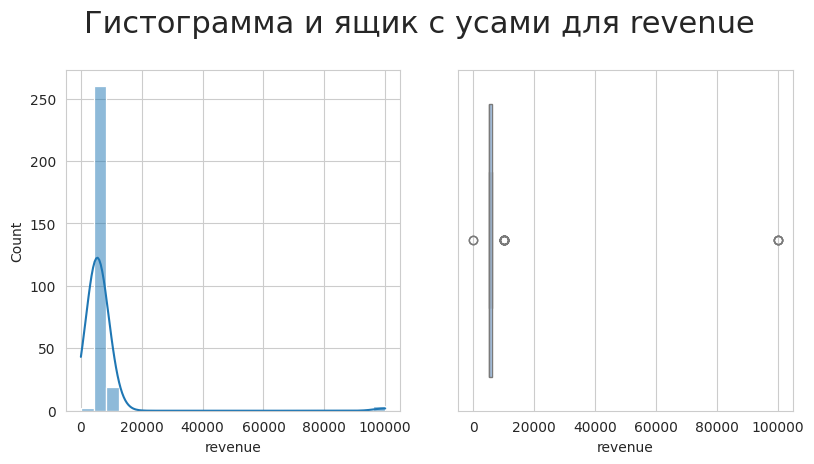

In [774]:
quantitative_analysis(df[df["revenue"].notna()], "revenue")

In [775]:
df["revenue"].value_counts()

revenue
4999.0      194
5999.0       66
9999.0       19
100000.0      4
1.0           2
Name: count, dtype: int64

Можно заметить, что есть выделяющиеся значения (100000 и 1). 
Их не так много и скорее всего это некорректность в данных. 

Чтобы не портить статистику такими выбросами, **было принято решение удалить выбросы**.

In [776]:
indices_to_drop = df[(df["revenue"] == 1) | (df["revenue"] == 100000)].index
df.drop(indices_to_drop, inplace=True)
print(f"Удалено {len(indices_to_drop)} рядов")

Удалено 6 рядов


### 1.1.8: session_duration_sec

Судя по графикам, есть супервыбросы

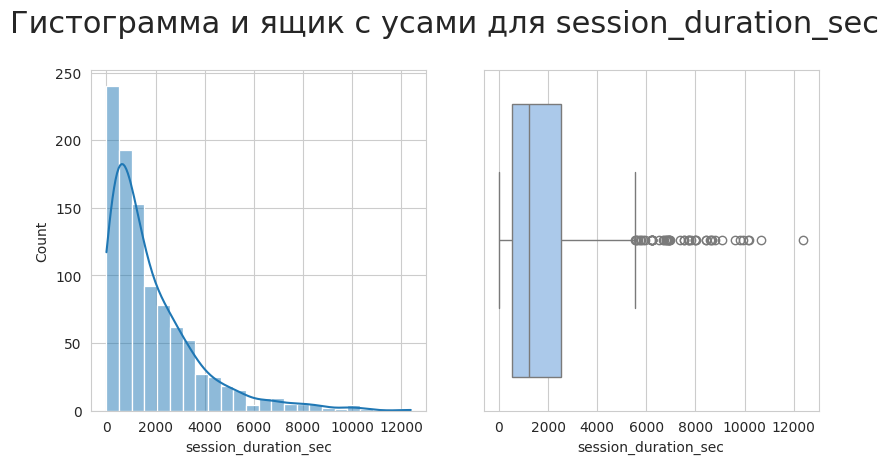

In [777]:
quantitative_analysis(df, "session_duration_sec")

Поскольку устройство может влиять на продолжительность сессии, заменим выбросы по каждому устройству на медиану по каждому устройству.

In [778]:
grouped_data = df.groupby("device")["session_duration_sec"].agg(["median", get_quantile_low, get_quantile_up])
grouped_data

,median,get_quantile_low,get_quantile_up
device,,,
Android,1301.0,-2723.125,5953.875
Mac,1267.5,-2508.750,5425.250
PC,1173.0,-2585.000,5871.000
iPhone,1171.0,-2224.625,5110.375
Неизвестен,1541.5,-1440.750,5623.250


In [779]:
for device in DEVICES:
    df.loc[(df["device"] == device) & ((df["session_duration_sec"] > grouped_data["get_quantile_up"][device]) | 
                                       (df["session_duration_sec"] < grouped_data["get_quantile_low"][device])), 
    "session_duration_sec"] = grouped_data["median"][device]

## 1.2: Новые метрики

### 1.2.1: revenue_with_discount
Итоговая сумма покупки с учетом применения промокода на скидку 10%

In [780]:
df['revenue_with_discount'] = df['revenue'] * (1 - df['promo_code'] * 0.1)
df.head()

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount
0,529697267522,США,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Мобильные платежи,0.0,9999.0
1,601292388085,США,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN
2,852898876338,США,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN
3,998513020664,США,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN
4,240702200943,США,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN


### 1.2.2: time_of_day

Временя суток визита

In [781]:
def part_of_day(hour):
    if 6 <= hour < 10:
        return 'утро'
    elif 10 <= hour < 17:
        return 'день'
    elif 17 <= hour < 22:
        return 'вечер'
    return 'ночь'


df['time_of_day'] = df['hour_of_day'].apply(part_of_day)

### 1.2.3: payer

столбец с информацией о том, является ли пользователь платящим или нет

In [782]:
df['payer'] = df['revenue'].apply(lambda x: 1 if x > 0 else 0)

## 1.3: Дубликаты

Найдено 3 дубликата. Принято решение их отбросить, потому что это явные ошибки в данных.

In [783]:
df[df[["user_id", "session_start", "session_end"]].duplicated()]

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
68,768710666,США,iPhone,реклама у блогеров,2019-05-17 18:24:36,2019-05-17 18:28:05,209.0,2019-05-17,5,5,18,2019-05-17 18:24:36,9999.0,Мобильные платежи,1.0,8999.1,вечер,1
196,134214602428,США,Android,социальные сети,2019-06-11 02:35:48,2019-06-11 03:45:47,4199.0,2019-06-11,6,2,3,2019-06-11 02:35:48,4999.0,Мобильные платежи,1.0,4499.1,ночь,1
600,16254498222,Неизвестен,Неизвестен,Неизвестен,2019-08-25 13:21:44,2019-08-25 13:43:23,1299.0,2019-08-25,8,7,13,2019-08-25 13:21:55,4999.0,Наличные,1.0,4499.1,день,1


In [784]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

## 1.4: Проверка дат на соответствие

Время покупки не находится в промежутке сессии, поменяем это.

In [785]:
df[(df['order_date'] < df['session_start']) | (df['order_date'] > df['session_end'])]

,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
279,324558127766,США,Android,социальные сети,2019-06-28 00:39:02,2019-06-28 02:34:25,1301.0,2019-06-28,6,5,2,2019-06-26 07:23:59,4999.0,Электронный кошелек,1.0,4499.1,ночь,1


In [786]:
df.loc[(df['order_date'] < df['session_start']) | (df['order_date'] > df['session_end']), "order_date"] = (
        df['session_start'] + (df['session_end'] - df['session_start']) / 2)

## 1.5 Выводы по первому шагу

- Столбы приведены к формату PEP8
- Выявлены и убраны опечатки в категориальных данных
- Убраны пропуски, где необходимо
- Убраны строки с некорректными данными
- Убраны супервыбросы
- Убраны дубликаты
- Перевод данных в соответствующий формат
- Новые метрики
- Перевод некоторых значений на русский язык

In [787]:
df.reset_index(drop=True, inplace=True)
df.to_csv("preprocessed_data.csv")
print(f"Size - {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Size - 998 rows and 18 columns.


,user_id,region,device,channel,session_start,session_end,session_duration_sec,session_date,month,day,hour_of_day,order_date,revenue,payment_type,promo_code,revenue_with_discount,time_of_day,payer
0,529697267522,США,iPhone,социальные сети,2019-05-01 00:06:40,2019-05-01 00:07:06,26.0,2019-05-01,5,3,0,2019-05-01 00:06:40,9999.0,Мобильные платежи,0.0,9999.0,ночь,1
1,601292388085,США,PC,без рекламы,2019-05-01 06:56:16,2019-05-01 07:09:18,782.0,2019-05-01,5,3,7,NaT,NaN,NaN,NaN,NaN,утро,0
2,852898876338,США,Mac,социальные сети,2019-05-01 04:30:45,2019-05-01 04:34:56,251.0,2019-05-01,5,3,4,NaT,NaN,NaN,NaN,NaN,ночь,0
3,998513020664,США,iPhone,социальные сети,2019-05-01 18:53:42,2019-05-01 18:57:35,233.0,2019-05-01,5,3,18,NaT,NaN,NaN,NaN,NaN,вечер,0
4,240702200943,США,Mac,социальные сети,2019-05-02 14:04:32,2019-05-02 14:09:51,319.0,2019-05-02,5,4,14,NaT,NaN,NaN,NaN,NaN,день,0


In [788]:
KNOWN = (df["region"] != "Неизвестен")
known_df = df[KNOWN]

# **Шаг 2: Аналитический и графический анализ данных**

### 2.1: Доля продаж по регионам

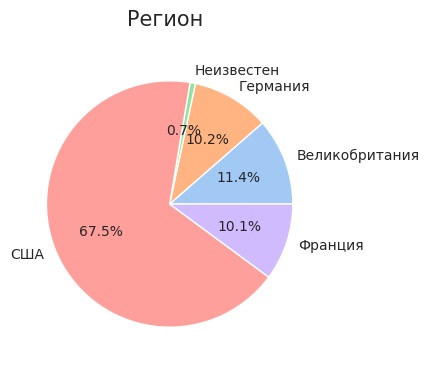

In [789]:
print_pie(df, "region", "Регион")

***Вывод:*** США является главным регионом продаж с долей в (67.5%). Другие страны Европы: Великобритания, Германия и Франция имеют примерно равные доли рынка (11.5%), (10.4%) и (10.4%) соответственно.

### 2.2: Доля продаж по источникам

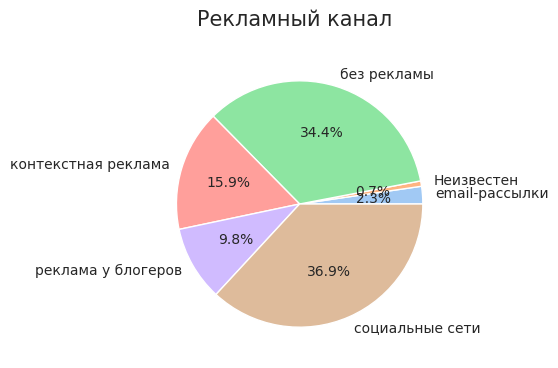

In [790]:
print_pie(df, "channel", "Рекламный канал")

***Вывод:*** Основной вклад в продажи вносят социальные сети с долей в (36.9%). Контекстная реклама также успешно привлекает внимание целевой аудитории, продажи с долей (15.9%). Реклама у блогеров занимает третье место в (9.8%), а email-рассылки имеют самую низкую долю продаж в (2.3%). При этом на рекламу не приходится целых (34.4%) от общего объема продаж + додумать что значит?

### 2.3: Доля продаж по устройствам

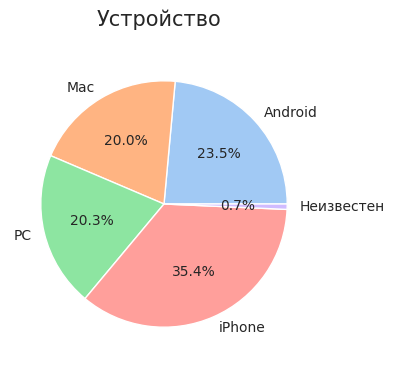

In [791]:
print_pie(df, "device", "Устройство")

***Вывод:*** Наибольшая доля продаж приходится на iPhone - (35.4%), за ним следует Android - (23.5%). Устройства Mac и PC имеют примерно равные доли рынка в (20%) и (20.3%).

### 2.4: Количество пользователей с разбивкой на платящих/не платящих по регионам

payer             0    1
region                  
Великобритания   83   31
Германия         78   24
США             483  191
Франция          78   23


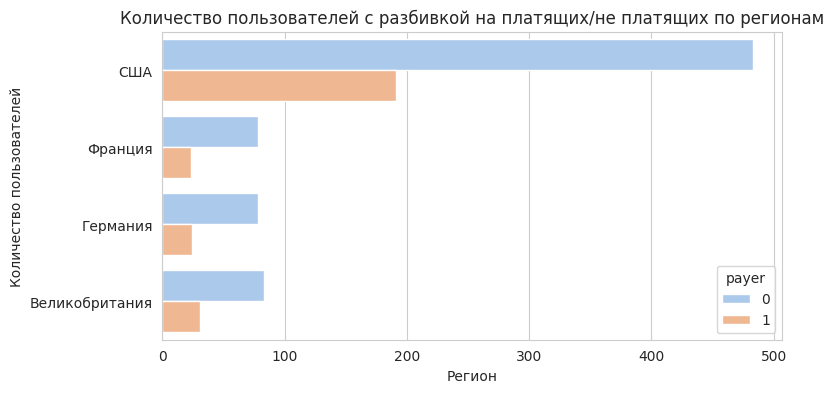

In [792]:
region_payers = known_df.groupby(['region', 'payer']).size().unstack()
print(region_payers)
print_count(known_df, 'region', 'payer', 'Регион', 'Количество пользователей', 'Количество пользователей с разбивкой на платящих/не платящих по регионам', orie='v')

***Вывод:*** Наибольшее количество плательщиков проживает в Соединенных Штатах (191), за ними следуют Великобритания (31), Германия и Франция с практически равным количеством человек (24 и 23).

Наибольшее количество неплательщиков также проживает в Соединенных Штатах (483), за ними идет Великобритания (83), Германия и Франция с равным количеством человек (78).

Общее количество пользователей больше всего в США, что может объяснить наибольшее количество и плательщиков, и неплательщиков в этой стране.


### 2.5: Количество пользователей с разбивкой на платящих/не платящих по устройствам

payer      0   1
device          
Android  164  71
Mac      142  58
PC       155  48
iPhone   261  92


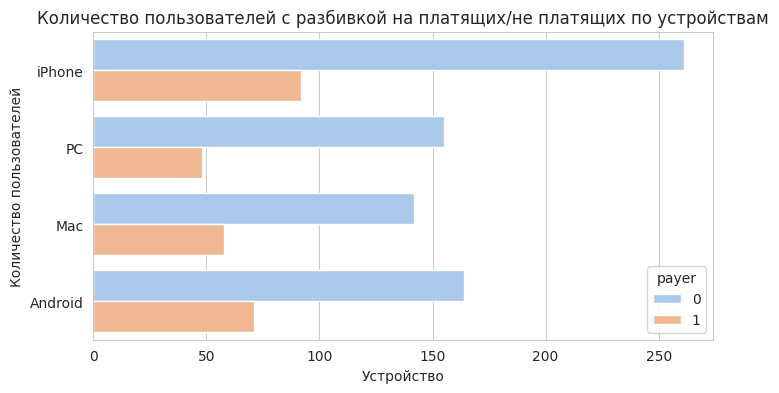

In [793]:
device_payers = known_df.groupby(['device', 'payer']).size().unstack()
print(device_payers)
print_count(known_df, 'device', 'payer', 'Устройство', 'Количество пользователей', 'Количество пользователей с разбивкой на платящих/не платящих по устройствам', orie='v')

***Вывод:*** Наибольшее количество плательщиков обладатели Iphone (92), за ними следуют пользователи Android (71), Mac и PC используют (58) и (48) плательщика.

Наибольшее количество неплательщиков обладатели Iphone (261), за ними следуют пользователи Android (164), Mac и PC используют (142) и (155) неплательщиков.

Общее количество пользователей iPhone и Android также больше, чем Mac и PC, что может объяснить более высокое количество плательщиков среди этих устройств.


### 2.6: Количество пользователей с разбивкой на платящих/не платящих по источникам

payer                  0    1
channel                      
email-рассылки        17    6
без рекламы          259   84
контекстная реклама  117   42
реклама у блогеров    71   27
социальные сети      258  110


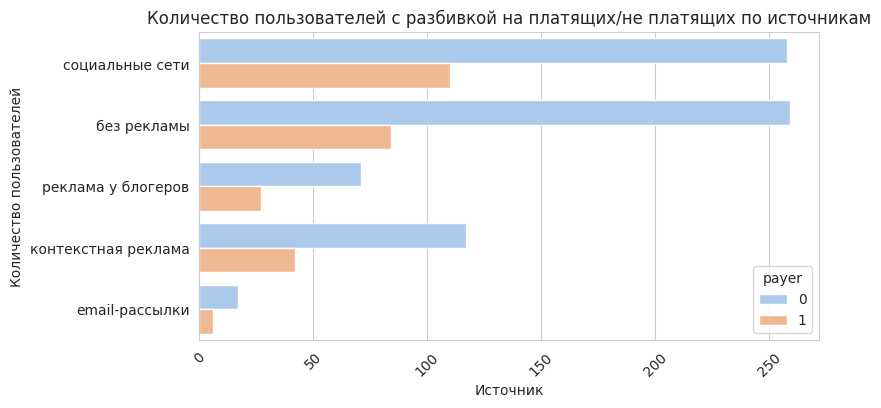

In [794]:
channel_payers = known_df.groupby(['channel', 'payer']).size().unstack()
print(channel_payers)

print_count(known_df, 'channel', 'payer', 'Источник', 'Количество пользователей', 'Количество пользователей с разбивкой на платящих/не платящих по источникам', orie='v', rt=45)

***Вывод:***   Наибольшее количество плательщиков предпочитают получать информацию из социальных сетей (110) и контекстной рекламы (42). Реклама у блогеров и email-рассылки привлекли (27) и (6) человек. Почти 32% плательщиков в размере (84) человек пришли без рекламы.

Наибольшее количество неплательщиков предпочитают получать информацию из социальных сетей (258) и контекстной рекламы (117). Реклама у блогеров и email-рассылки привлекли (71) и (17) человек. Почти 36% неплательщиков в размере (259) человек пришли без рекламы.

### 2.7: График сезонности в продажах по месяцам  

   month  revenue_with_discount
0      5               154575.3
1      6               267552.4
2      7               226758.1
3      8               396029.5
4      9               196362.8
5     10               248754.0


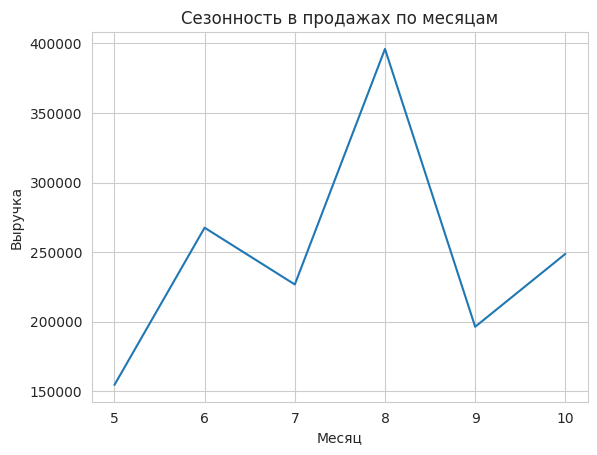

In [795]:
month_rev = df.groupby('month')['revenue_with_discount'].sum().reset_index()
print(month_rev)
print_lineplot(month_rev,'month', 'revenue_with_discount', 'Сезонность в продажах по месяцам', 'Месяц', 'Выручка')

***Вывод:*** Самым прибыльным месяцем был август, выручка составила (396029.5), что в три раза превышает самую маленькую выручку - в мае (154575.3). Июнь, июль и октябрь имели примерно равную вырочку в (267552.4), (226758.1) и (248754.0). В сентябре выручка была средней - (196362.8).

### 2.8: График сезонности в продажах по дням недели

   day  revenue_with_discount
0    1               209260.7
1    2               205662.0
2    3               205665.1
3    4               199365.0
4    5               248155.0
5    6               220559.5
6    7               201364.8


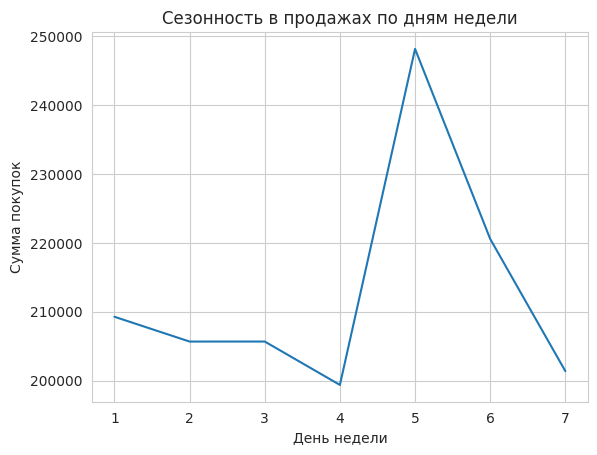

In [796]:
day_rev = df.groupby('day')['revenue_with_discount'].sum().reset_index()
print(day_rev)
print_lineplot(day_rev, 'day', 'revenue_with_discount', 'Сезонность в продажах по дням недели', 'День недели', 'Сумма покупок')

***Вывод:*** Самый прибыльный день недели - пятница, прибыль за пятницы составила (248155.0), за ней следует суббота (220559.5). Самая маленькая прибыль по четвергам (199365.0). Есть тенденция снижения прибыли с понедельника по четверг, затем большая выручка в пятницу и снова снижение дохода до воскресенья.


### 2.9: График сезонности в продажах по времени суток

  time_of_day  revenue_with_discount
3        утро               291145.7
1        день               377832.8
0       вечер               325542.3
2        ночь               495511.3


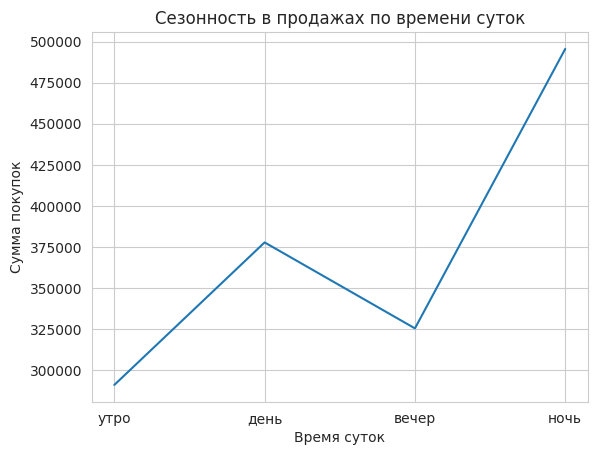

In [797]:
torder = ['утро', 'день', 'вечер', 'ночь']
time_rev = df.groupby('time_of_day')['revenue_with_discount'].sum().reset_index()
time_rev['time_of_day'] = pd.Categorical(time_rev['time_of_day'], categories=torder, ordered=True)
time_rev = time_rev.sort_values('time_of_day')
print(time_rev)
print_lineplot(time_rev, 'time_of_day', 'revenue_with_discount', 'Сезонность в продажах по времени суток', 'Время суток', 'Сумма покупок')

***Вывод:*** Наиболее прибыльное время суток - ночь(с 22 до 6 утра) 495511.3.  Наименьшая прибыль, которая в 1.7 раза меньше ночной, зафиксирована утром (с 6 до 10 утра) (291145.7). Продажи днем и вечером составили (377832.8) и (325542.3).

### 2.10: Диаграмма количества покупок по типу оплаты

payment_type
Кредитная карта        34
Дебетовая карта        35
Наличные               60
Электронный кошелек    65
Мобильные платежи      82
Name: count, dtype: int64


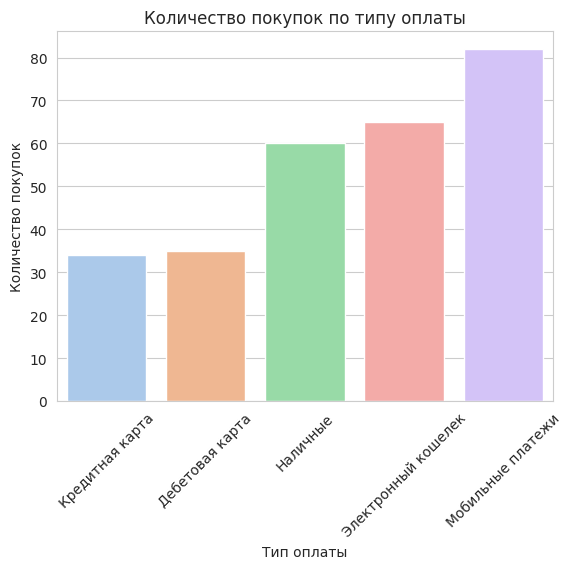

In [798]:
pay_count = df['payment_type'].value_counts()
pay_count = pay_count.sort_values()
print(pay_count)

print_barplot(pay_count, 'Количество покупок по типу оплаты', 'Тип оплаты', 'Количество покупок', 45)

***Вывод:*** Самым популярным способом оплаты являются мобильные платежи (82). Затем идут электронные кошельки (65) и наличные (60). Кредитными и дебетовыми картами пользуются реже всего: (34) и (35). Возможно, это связано с ростом популярности мобильных приложений для оплаты и удобством использования электронных кошельков. Однако, оплата наличными также остается популярным способом оплаты.

# **Шаг 3: Проведение расчетов**

### 3.1: Средний чек

In [799]:
av_check= df['revenue_with_discount'].mean()
av_check2 = df['revenue'].mean()
print(av_check, av_check2)

5398.6670289855065 5564.217391304348


***Вывод:*** Cредний чек покупателя с учетом скидки составляет (5398), без скидки (5564).

### 3.2: Среднее количество покупок на одного пользователя

In [800]:
buys_per_user = df.groupby('user_id')['order_date'].count().mean()
print(buys_per_user)

0.2782258064516129


***Вывод:*** Среднее количество покупок на одного пользователя составляет примерно (0.278), то есть пользователи совершают покупки достаточно редко. Нам нужно понять, как можно увеличить активность пользователей и количество покупок.

### 3.3: Средняя продолжительность сессии по рекламным каналам

channel
email-рассылки         1409.043478
без рекламы            1418.849854
социальные сети        1456.206522
реклама у блогеров     1636.127551
контекстная реклама    1729.984277
Name: session_duration_sec, dtype: float64


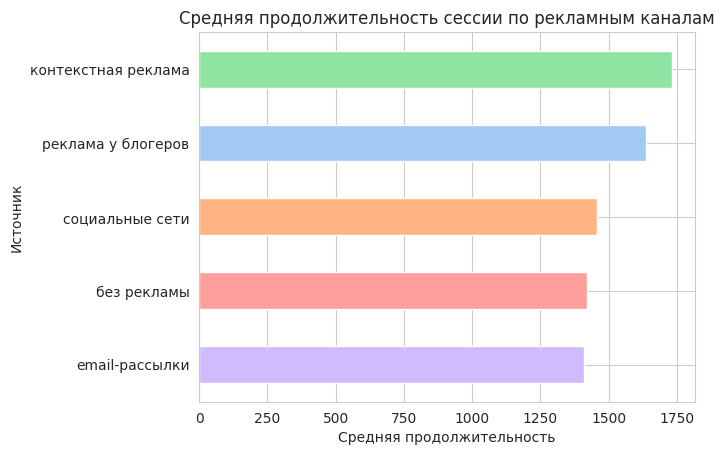

In [801]:
session_by_chan = known_df.groupby('channel')['session_duration_sec'].mean()
session_by_chan = session_by_chan.sort_values()
print(session_by_chan)
session_by_chan.plot(kind='barh', color=COLORS)
plt.xlabel('Средняя продолжительность')
plt.ylabel('Источник')
plt.title('Средняя продолжительность сессии по рекламным каналам')
plt.show()

***Вывод:*** Наибольшее время на сайте проводят пользователи, пришедшие по контекстной рекламе (1729.98). За ней следует реклама у блогеров (1636.127551). Пользователи пришедшие по социальным сетям и без рекламы имеют примерно равное время на сайте (1456.20) и (1418.84). Наименьшее время на сайте проводят пользователи пришедшие из email-рассылок (1409.04).

Контекстная реклама и email-рассылки являются наиболее эффективным каналами, а значит, при распределении бюджета на рекламу им стоит уделить большее внимание.

### 3.4: Рассчитать среднюю продолжительность сессии по типу устройства

device
iPhone     1428.286119
Mac        1480.717500
Android    1540.131915
PC         1616.285714
Name: session_duration_sec, dtype: float64


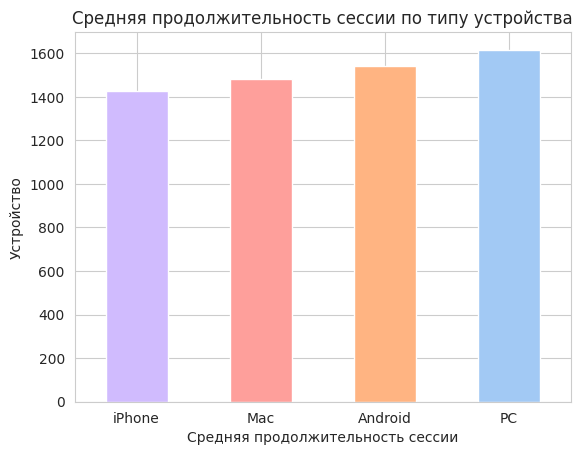

In [802]:
session_by_dev = known_df.groupby('device')['session_duration_sec'].mean()
session_by_dev = session_by_dev.sort_values()
print(session_by_dev)
session_by_dev.plot(kind='bar', color=COLORS)
plt.xlabel('Средняя продолжительность сессии')
plt.xticks(rotation=0)
plt.ylabel('Устройство')
plt.title('Средняя продолжительность сессии по типу устройства')
plt.show()

***Вывод:*** Пользователи PC проводят на сайте больше всех времени (1616.28). Затем идут пользователи Android (1540.13) и Mac (1480.71). Наименьшее количество времени на сайте проводят обладатели iPhone (1428.28).



### 3.5: Топ-3 рекламных канала по среднему чеку

channel
социальные сети       5525.390000
без рекламы           5432.365476
реклама у блогеров    5380.496296
Name: revenue_with_discount, dtype: float64


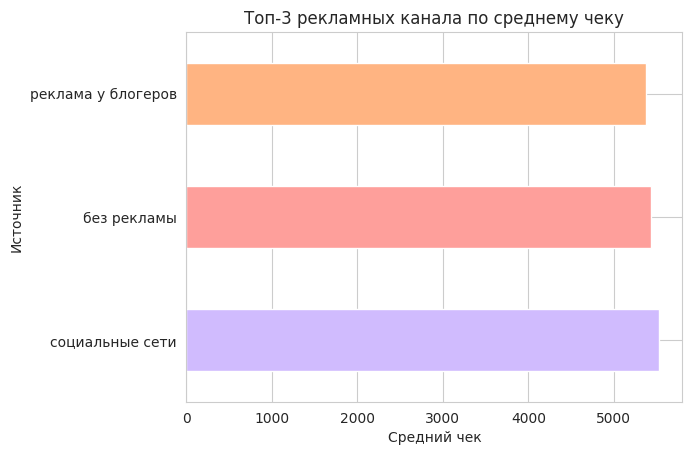

In [803]:
top3_ch = df.groupby('channel')['revenue_with_discount'].mean().sort_values(ascending=False).head(3)
print(top3_ch)
top3_ch.plot(kind='barh', color=COLORS)
plt.xlabel('Средний чек')
plt.ylabel('Источник')
plt.title('Топ-3 рекламных канала по среднему чеку')
plt.show()

***Вывод:*** Топ-3 рекламных канала по среднему чеку


1.   социальные сети       5525.39
2.   без рекламы           5432.36
3.   реклама у блогеров    5380.49

Email-рассылки являются самым прибыльным рекламным каналом по среднему чеку(5332.37). Возможно потому, что чаще всего email-рассылки приходят именно целевой аудитории, уже знающей о продукте. Реклама у блогеров занимает второе место (5241.32). А значит, были выбраны подходящие блогеры с заинтересованными в нашем продукте подписчиками.  Социальные сети занимают третье место по среднему чеку (5130.656).

Есть ли смысл графика?




### 3.6: Топ-3 региона по среднему чеку

region
Великобритания    5540.954839
США               5422.067539
Германия          5344.862500
Name: revenue_with_discount, dtype: float64


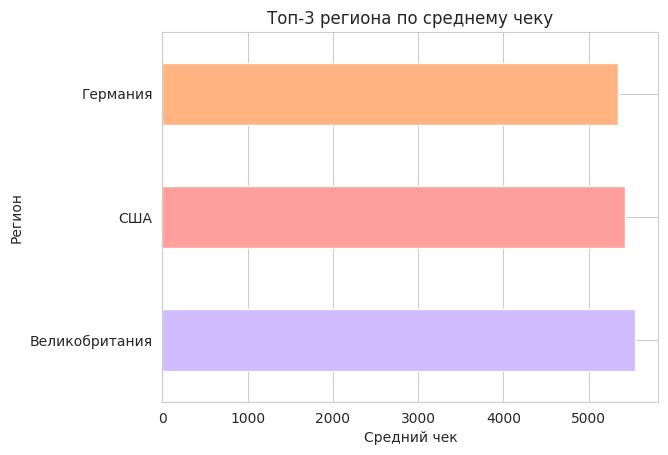

In [804]:
top3_reg = df.groupby('region')['revenue_with_discount'].mean().nlargest(3)
print(top3_reg)
top3_reg.plot(kind='barh', color=COLORS)
plt.xlabel('Средний чек')
plt.ylabel('Регион')
plt.title('Топ-3 региона по среднему чеку')
plt.show()

***Вывод:*** Топ-3 региона по среднему чеку

* Великобритания    5540.95
* США               5422.06
* Германия          5344.86

Франция занимает первое место регионов по среднему чеку (5255.55).
Второе место занимает Великобритания, с средним чеком в (5233.50).
На третьем месте находится Германия, с средним чеком в (5142.51).
(Возможно в этих странах разработка дронов вообще не ведется, в отличие от сша например, поэтому скупают)-додумать. +
график нужен?

### 3.7: Топ-3 месяца по среднему чеку с разбивкой по регионам

month  region        
7      Германия          7499.000000
5      США               6159.050000
10     Великобритания    6056.157143
Name: revenue_with_discount, dtype: float64


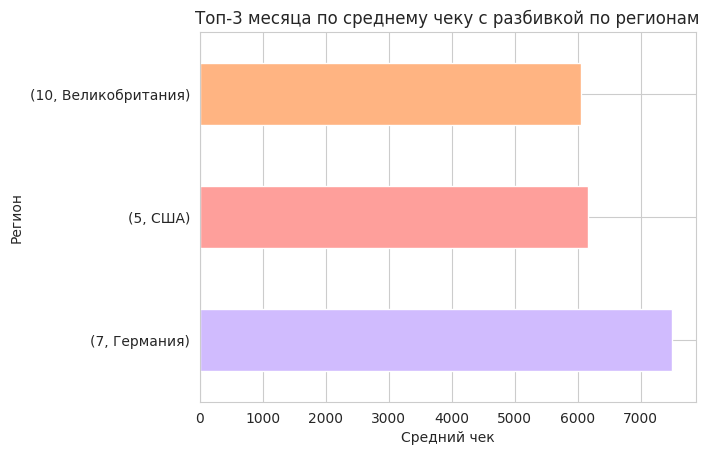

In [805]:
top3_month= df.groupby(['month', 'region'])['revenue_with_discount'].mean().nlargest(3)
print(top3_month)
top3_month.plot(kind='barh', color=COLORS)
plt.xlabel('Средний чек')
plt.ylabel('Регион')
plt.title('Топ-3 месяца по среднему чеку с разбивкой по регионам')
plt.show()

***Вывод:*** У Германии самый высокий средний чек среди всех регионов в июле (7499). США также занимает второе место по среднему чеку в мае (6159). Также высокий средний чек у Великобритании в октябре (6056.15).

### 3.8: MAU - (количество уникальных пользователей за месяц) по каждому месяцу с разбивкой по рекламным каналам

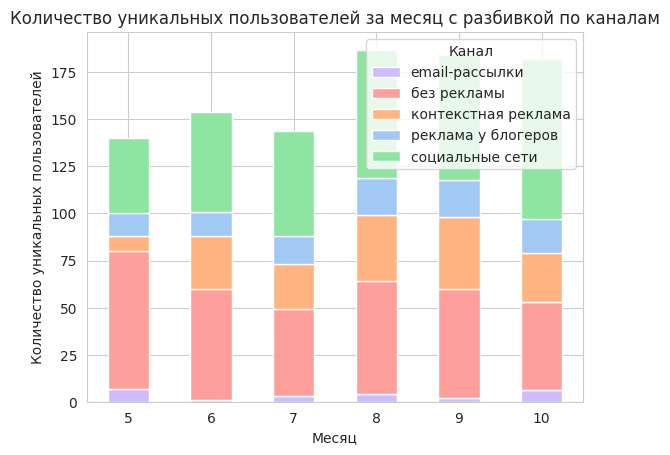

In [806]:
mau = known_df.groupby(['month', 'channel'])['user_id'].nunique().unstack()
mau.plot(kind='bar', stacked=True, color=COLORS)
plt.xlabel('Месяц')
plt.xticks(rotation=0)
plt.ylabel('Количество уникальных пользователей')
plt.title('Количество уникальных пользователей за месяц с разбивкой по каналам')
plt.legend(title='Канал')
plt.show()

***Вывод:*** Наибольшее количество уникальных пользователей во всех месяцах приходит из социальных сетей, это наиболее эффективный канал для привлечения пользователей.

Количество пользователей, приходящих из контекстной и блогерской рекламы может меняться в зависимости от месяца.

Email-рассылки показывают наименьшее количество уникальных пользователей среди всех рекламных каналов в каждом месяце.

В целом,радует положительная динамика роста количества уникальных пользователей с каждым месяцем.

### 3.9 Топ-3 рекламных каналов по количеству уникальных пользователей в месяц

channel
социальные сети        368
без рекламы            343
контекстная реклама    159
реклама у блогеров      98
dtype: int64


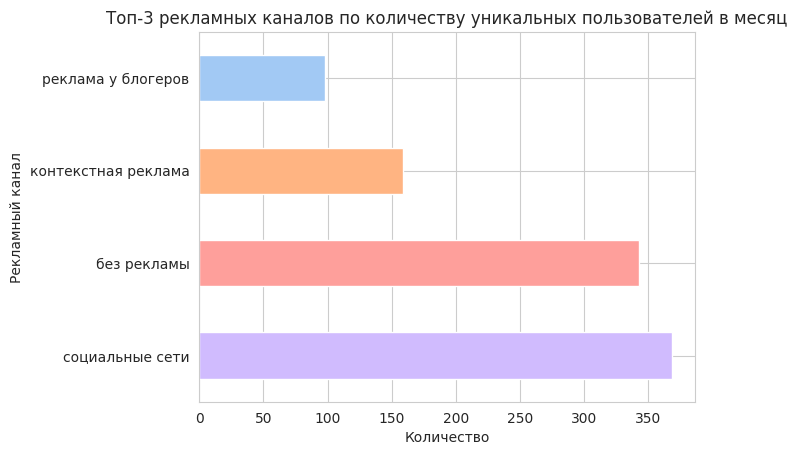

In [807]:
top3mau = mau.sum(axis=0).nlargest(4)
print(top3mau)
top3mau.plot(kind='barh', color=COLORS)
plt.xlabel('Количество')
plt.ylabel('Рекламный канал')
plt.title('Топ-3 рекламных каналов по количеству уникальных пользователей в месяц')
plt.show()

***Вывод:*** Самым эффективным каналом привлечения уникальных пользователей становятся социальные сети, привлекая (368) пользователей. На втором месте идет контекстная реклама, которая привлекла (159) человек. Наконец, на третьем месте реклама у блогеров (98).

### 3.10: Таблица по рекламным каналам (количество пользователей, уникальных пользователей, платящих пользователей, сумма продаж)

In [808]:
def count_payers(payer_column):
    return np.sum(payer_column == 1)


new_df = known_df.groupby("channel").agg({
    "user_id": ["size", "nunique"],
    "payer": count_payers,
    "revenue_with_discount": "sum"
})
new_df.columns = ['users', 'unique_users', 'payers', 'total_revenue']

new_df

,users,unique_users,payers,total_revenue
channel,,,,
email-рассылки,23,23,6,31994.2
без рекламы,343,343,84,456318.7
контекстная реклама,159,159,42,215159.6
реклама у блогеров,98,98,27,145273.4
социальные сети,368,368,110,607792.9


**Вывод:**

# **Шаг 4: Проверка гипотез**

### 4.1: Влияет ли тип устройства на количество покупок в день по каждому региону?

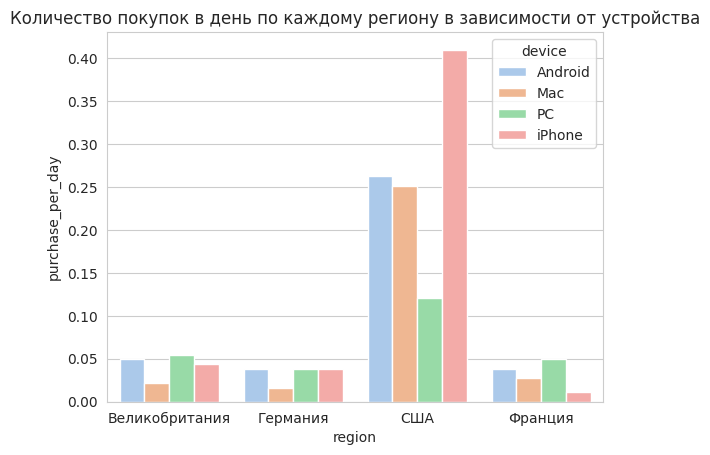

In [809]:
orders = known_df[df['order_date'].notnull()]
days_count = (df["session_date"].max() - df["session_date"].min()).days # количество дней в диапазоне дат

grouped_data = orders.groupby(['region', 'device']).size().apply(lambda x: x / days_count).reset_index(name='purchase_per_day')

sns.barplot(data=grouped_data, x='region', y='purchase_per_day', hue='device', palette=PALETTE)
plt.title("Количество покупок в день по каждому региону в зависимости от устройства")
plt.show()

Из приведённого ниже графика мы можем сделать следующие **выводы**:

1) Во всех регионах значимую часть покупателей занимают обладатели Android устройств.
2) В самом прибыльном регионе (США) чаще всего совершают покупки обладатели IOS устройств. Это связано с тем, что в Америке IOS устройства пользуются огромным спросом.

### 4.2: Влияет ли тип рекламного канала на количество покупок в день по каждому региону?

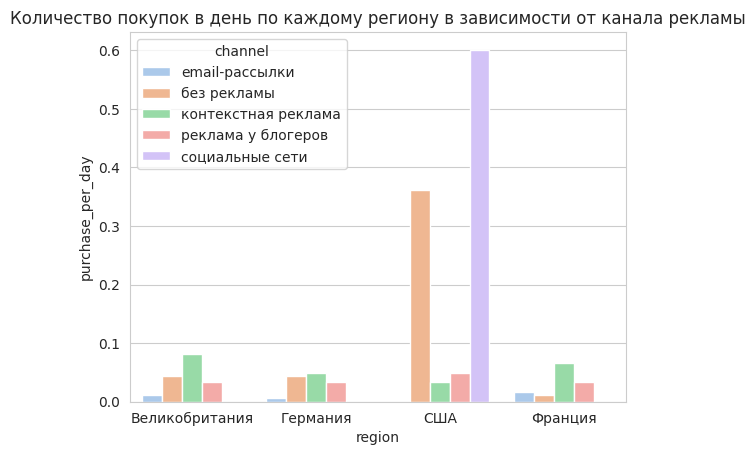

In [810]:
grouped_data = orders.groupby(['region', 'channel']).size().apply(
    lambda x: x / days_count
).reset_index(name='purchase_per_day')

sns.barplot(data=grouped_data, x='region', y='purchase_per_day', hue='channel', palette=PALETTE)
plt.title("Количество покупок в день по каждому региону в зависимости от канала рекламы")
plt.show()

Из приведённого ниже графика мы можем сделать следующие **выводы**:

1) В Америке чаще всего совершают покупки те, кто узнал о магазине через социальные сети. Разница между каналами рекламы очень существенная. Реклама у блогеров и контекстная реклама не приносят столько же, поэтому, возможно, следует отказаться от этих способов. Также многие покупатели узнают о магазине не из рекламы.
2) В остальных регионах о магазине не узнают из соц сетей. На примере Америки, это был самый эффективный способ рекламы магазина, поэтому стоит попробовать рекламировать магазин через соцальные сети и в других регионах.
3) В Германии, Великобритании и Франции самый эффективный канал рекламы - контекстная реклама.
4) Email-рассылки - самый неэффективный канал рекламы. Возможно, следует отказаться от этого способа.

### 4.3: Отличается ли cредний чек отличается в зависимости от регионам?

In [811]:
grouped_data = orders.groupby('region')["revenue_with_discount"].mean().reset_index(name='average_revenue')
grouped_data

,region,average_revenue
0,Великобритания,5540.954839
1,Германия,5344.862500
2,США,5422.067539
3,Франция,5255.547826


Средние чеки отличаются в каждом регионе, но это ещё не означает, что регион влияет на него.
Найдём p-value.

**H0: регион не влияет на средний чек** 

**HA: регион влияет на средний чек**

In [812]:
if check_normality(df["revenue_with_discount"]):
    print("Данные распределены нормально")
else:
    print("Данные распределены ненормально")

Данные распределены ненормально


Поскольку данные распределены ненормально, для нахождения p-value будем использовать метод Крускала-Уоллиса.

In [813]:
arr = []
for region in REGIONS:
    arr.append(df[(df["region"] == region) & (df["payer"] == 1)]["revenue_with_discount"])
_, p_val = st.kruskal(*arr)

print(f"P-value: {p_val}")

P-value: 0.22904787067298704


**Вывод:** Поскольку *p-value* примерно составляет 0.23, что больше стандартного уровня значимости 0.05, мы не можем отклонить нулевую гипотезу (H0). Регион не влияет на средний чек.

### 4.4: Cредний чек отличается в зависимости от рекламного канала?

### 4.5: Cредний чек отличается в зависимости от времени суток?

### 4.6: Есть ли взаимосвязь между продолжительностью сессии и суммой покупок?

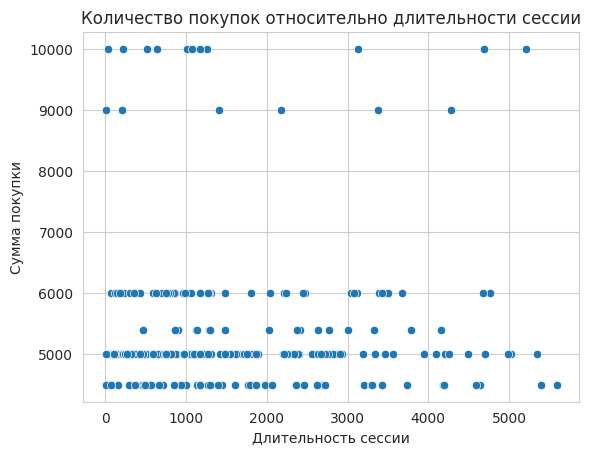

In [814]:
sns.scatterplot(data=df, y="revenue_with_discount", x='session_duration_sec', palette=PALETTE)
plt.xlabel('Длительность сессии')
plt.ylabel('Сумма покупки')
plt.title('Количество покупок относительно длительности сессии')
plt.show()

Судя по графику связи нет. Подкрепим это утверждение коэффициентом корреляции.

In [815]:
k = df[["revenue_with_discount", "session_duration_sec"]].corr().loc["revenue_with_discount", "session_duration_sec"]
print(f"Корреляция между выручкой с учетом скидки и длительностью сеанса: {k}")

Корреляция между выручкой с учетом скидки и длительностью сеанса: 0.021845383932809805


Корреляция между этими двумя факторами ничтожно мала.

**Вывод:** взаимосвязи между продолжительностью сессии и суммой покупок нет.

### 4.7: Придумать

### 4.8: Придумать

# Шаг 5: Регрессионное моделирование

## 5.1: Все регионы

### 5.1.0: Подготовка

Чтобы понять, насколько развивается бизнес, требуется:

- Добавить фактор, выражающий количество покупок ежемесячно.
- Посчитать, сколько раз встречаются уникальные значения номинальных шкал ежемесячно.
- Убрать неподходящие для обучения шкалы (id, номинальные и даты)

Возьмём количество продаж в месяц за **целевой фактор**

In [816]:
month_purchases = known_df[known_df["payer"] == 1].groupby("month")["revenue_with_discount"].count()

timestamp_columns = known_df.select_dtypes(include=['datetime64']).columns
nominal_columns = known_df.select_dtypes(include=[object]).columns

regr_df = known_df.drop(columns=[*timestamp_columns, "user_id", "revenue"])
regr_df["month_revenue"] = regr_df["month"].map(month_purchases)

channels = regr_df.groupby("month")["channel"].value_counts().unstack(fill_value=0)
for channel in known_df["channel"].unique():
    regr_df[channel.replace(" ", "_")] = regr_df["month"].map(channels[channel])

devices = regr_df.groupby("month")["device"].value_counts().unstack(fill_value=0)
for device in known_df["device"].unique():
    regr_df[device.replace(" ", "_").lower()] = regr_df["month"].map(devices[device])

regr_df.drop(columns=nominal_columns, inplace=True)

### 5.1.1: Выбор факторов

Чтобы понять, какие факторы влияют на целевой фактор (количество покупок ежемесячно), необходимо узнать коэф-ы корреляций. Возьмём самый большой по модулю.

In [817]:
correlations = regr_df.corr()["month_revenue"].sort_values(key=abs, ascending=False)
top_correlations = correlations[abs(correlations) >= 0.5][1:]
top_correlation = top_correlations.index[0]
top_correlations

android                0.726282
контекстная_реклама    0.586167
iphone                 0.576497
реклама_у_блогеров     0.508868
Name: month_revenue, dtype: float64

Было принято решение взять **количество сессий на Android в месяц** как **предсказываемый фактор**

### 5.1.2: Модель и предсказание

Разделим выборку на тренировочную и тестовую. Подставим в модель линейной регрессии тренировочную. Предскажем **количество покупок в месяц**.

In [818]:
X_train, X_test, y_train, y_test = train_test_split(
    regr_df[[top_correlation]], regr_df["month_revenue"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### 5.1.3: Метрики

In [819]:
metric_values = (y_test, predictions)

mae = metrics.mean_absolute_error(*metric_values)
mse = metrics.mean_squared_error(*metric_values)
r2 = metrics.r2_score(*metric_values)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 7.500312999846803
MSE: 80.27329896295578
R^2: 0.5819891377124874


Из полученных метрик, можно сделать **вывод**, что **модель относительно точная**.

### 5.1.4: Корреляция предсказания и реальных данных

In [820]:
prediction_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prediction_vs_actual_corr = prediction_vs_actual.corr()["Actual"]["Predicted"]

print(f"Корреляция между предсказанными и реальными данными: {prediction_vs_actual_corr}")

Корреляция между предсказанными и реальными данными: 0.7698752255546927


Из полученных данных, можно убедиться, что **наша модель относительно точная**.

### 5.1.5: Регрессия графически

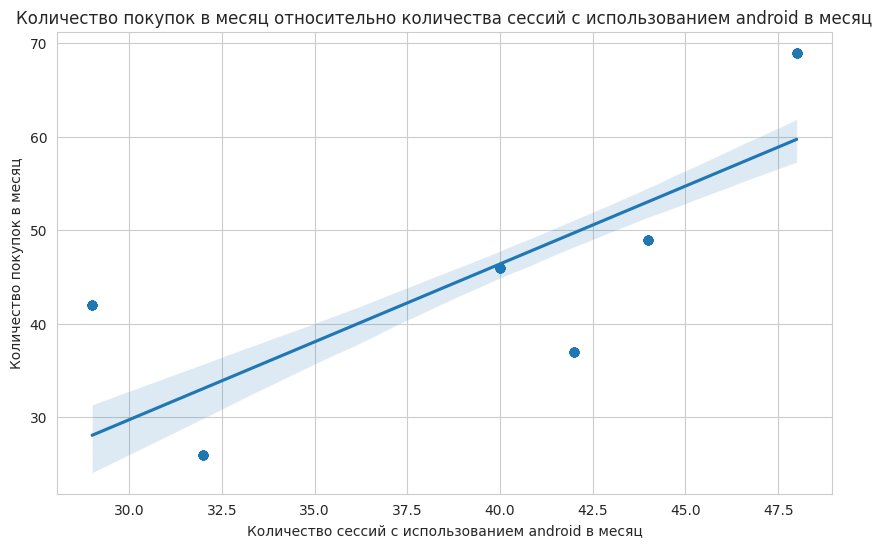

In [821]:
regression_visual(X_test, y_test, predictions, top_correlation)

### 5.1.6: Вывод

Можно наблюдать **тенденцию** роста продаж в месяц для пользователей Android.

## 5.2: Регион США

Я считаю, что регион США нужно рассмотреть отдельно, тк в этом регионе больше всего продаж.

### 5.2.0: Подготовка

Чтобы понять, насколько развивается бизнес, требуется:

- Добавить фактор, выражающий количество покупок ежемесячно.
- Посчитать, сколько раз встречаются уникальные значения номинальных шкал ежемесячно.
- Убрать неподходящие для обучения шкалы (id, номинальные и даты)

Возьмём количество продаж в месяц за **целевой фактор**

In [822]:
condition = df["region"] == "США"

month_purchases = known_df[(known_df["payer"] == 1) & condition].groupby("month")["revenue_with_discount"].count()

regr_df = known_df[condition].drop(columns=[*timestamp_columns, "user_id", "revenue"])
regr_df["month_revenue"] = regr_df["month"].map(month_purchases)

channels = regr_df.groupby("month")["channel"].value_counts().unstack(fill_value=0)
for channel in known_df[condition]["channel"].unique():
    regr_df[channel.replace(" ", "_")] = regr_df["month"].map(channels[channel])

devices = regr_df.groupby("month")["device"].value_counts().unstack(fill_value=0)
for device in known_df[condition]["device"].unique():
    regr_df[device.replace(" ", "_").lower()] = regr_df["month"].map(devices[device])

regr_df.drop(columns=nominal_columns, inplace=True)

### 5.2.1: Выбор факторов

Чтобы понять, какие факторы влияют на целевой фактор (количество покупок ежемесячно), необходимо узнать коэф-ы корреляций. 

Возьмём **социальные сети**, потому что из п. 4.2 социальные сети - самый популярный канал связи и его нет в других регионах.

In [823]:
correlations = regr_df.corr()["month_revenue"].sort_values(key=abs, ascending=False)
top_correlations = correlations[abs(correlations) >= 0.45][1:]
top_correlation = top_correlations.index[2]
top_correlations

контекстная_реклама    0.695726
android                0.475709
социальные_сети        0.468098
без_рекламы           -0.450628
Name: month_revenue, dtype: float64

Проверим, как влияет реклама через **социальные сети** на кол-во покупок в месяц, тем самым дополним выводы по шагу 4.2.

### 5.2.2: Модель и предсказание

Разделим выборку на тренировочную и тестовую. Подставим в модель линейной регрессии тренировочную. Предскажем **количество покупок в месяц**.

In [824]:
X_train, X_test, y_train, y_test = train_test_split(
    regr_df[[top_correlation]], regr_df["month_revenue"],
    test_size=TEST_SIZE, random_state=RANDOM_STATE
)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

### 5.2.3: Метрики

In [825]:
mae = metrics.mean_absolute_error(y_test, predictions)
mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R^2: {r2}")

MAE: 5.8674308415975105
MSE: 47.8648993830157
R^2: 0.28116527561005866


Из полученных метрик, можно сделать **вывод**, что наша модель относительно **точная**. Она могла быть точнее, если бы было больше данных.

### 5.2.4: Корреляция предсказания и реальных данных

In [826]:
prediction_vs_actual = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
prediction_vs_actual_corr = prediction_vs_actual.corr()["Actual"]["Predicted"]

print(f"Корреляция между предсказанными и реальными данными: {prediction_vs_actual_corr}")

Корреляция между предсказанными и реальными данными: 0.5371468201586305


Из полученных данных, можно убедиться, что наша модель относительно **точно** предсказала значения целевого фактора.

### 5.2.5: Регрессия графически

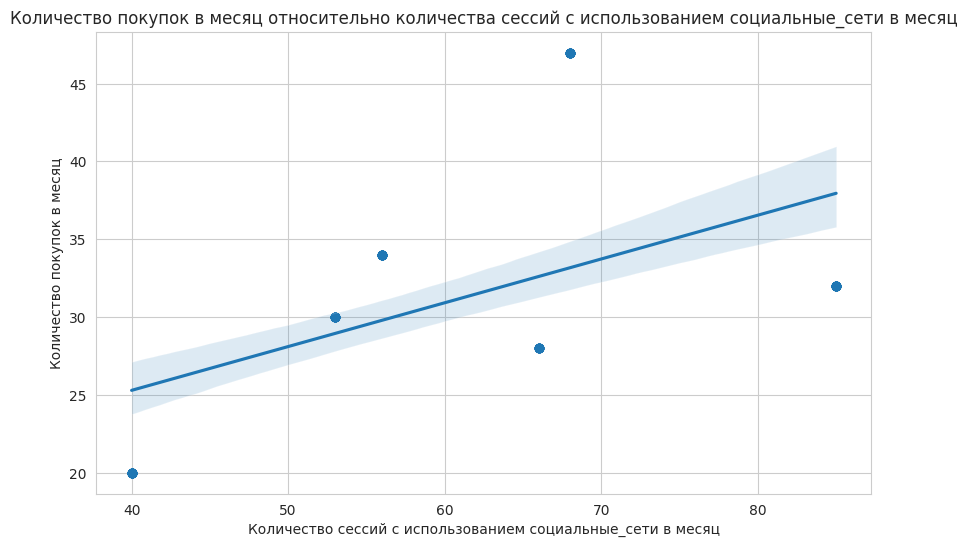

In [827]:
regression_visual(X_test, y_test, predictions, top_correlation)

### 5.2.6: Вывод

Можно наблюдать **тенденцию** роста продаж в месяц для пользователей, получающих рекламу через социальные сети. Нужно развивать маркетинг в социальных сетях не только в Америке, но и в остальных регионах.

## 5.3: Вывод по пятому шагу

В полученных данных нет метрик, судя по которым можно предсказать продажи. Единственное, что можно сделать, это выявить тенденцию. Также данных не так много, поэтому расчёты могут быть не самыми точными (см. 5.1.3 и 5.2.3).

# Общие выводы